In [1]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
# config settings

# date of forecast generation
#forecast_date = datetime.today().date()
forecast_date = "2024-10-13"
 #"2024-11-24", "2024-12-22"

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
q_labels = ['0.025', '0.05', '0.1', '0.25', '0.5', '0.75',  '0.9', '0.95', '0.975']


AttributeError: 'str' object has no attribute 'weekday'

In [3]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [4]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [5]:
dat = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast/target-data/oracle-output.csv')
dat

,Unnamed: 0,target_end_date,location,target,oracle_value,population
0,1,2024-10-05,Bronx,ILI ED Visits,419,1472654
1,2,2024-10-12,Bronx,ILI ED Visits,469,1472654
2,3,2024-10-19,Bronx,ILI ED Visits,521,1472654
3,4,2024-10-26,Bronx,ILI ED Visits,562,1472654
4,5,2024-11-02,Bronx,ILI ED Visits,468,1472654
...,...,...,...,...,...,...
2904,2905,2024-11-30,Staten Island,ILI ED Visits,66,495747
2905,2906,2024-12-07,Staten Island,ILI ED Visits,89,495747
2906,2907,2024-12-14,Staten Island,ILI ED Visits,99,495747
2907,2908,2024-12-21,Staten Island,ILI ED Visits,111,495747


In [6]:
dat['inc'] = dat['oracle_value']/(dat['population']/ 100000)
dat['target_end_date'] = pd.to_datetime(dat['target_end_date'])
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'target_end_date': 'wk_end_date'}, inplace=True)
dat = dat[['wk_end_date', 'location', 'inc', 'pop']]
dat = dat[dat['wk_end_date'] < pd.Timestamp(ref_date)]
dat

,wk_end_date,location,inc,pop
0,2024-10-05,Bronx,28.452033,1472654
1,2024-10-12,Bronx,31.847264,1472654
2,2024-10-19,Bronx,35.378303,1472654
3,2024-10-26,Bronx,38.162393,1472654
4,2024-11-02,Bronx,31.779359,1472654
...,...,...,...,...
2904,2024-11-30,Staten Island,13.313242,495747
2905,2024-12-07,Staten Island,17.952706,495747
2906,2024-12-14,Staten Island,19.969864,495747
2907,2024-12-21,Staten Island,22.390453,495747


In [7]:
dat['wk_end_date'].max()

Timestamp('2025-01-18 00:00:00')

In [8]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['wk_end_date'].dt.isocalendar().week,
    year=dat['wk_end_date'].dt.year
)


dat_arrange = dat_arrange.assign(
    season=lambda x: x['year'].astype(str) + "/" + (x['year'] + 1).astype(str).str[-2:])
dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
df = dat_arrange
df


,wk_end_date,location,inc,pop,epiweek,year,season,season_week
0,2024-10-05,Bronx,28.452033,1472654,40,2024,2024/25,10
1,2024-10-12,Bronx,31.847264,1472654,41,2024,2024/25,11
2,2024-10-19,Bronx,35.378303,1472654,42,2024,2024/25,12
3,2024-10-26,Bronx,38.162393,1472654,43,2024,2024/25,13
4,2024-11-02,Bronx,31.779359,1472654,44,2024,2024/25,14
...,...,...,...,...,...,...,...,...
2904,2024-11-30,Staten Island,13.313242,495747,48,2024,2024/25,18
2905,2024-12-07,Staten Island,17.952706,495747,49,2024,2024/25,19
2906,2024-12-14,Staten Island,19.969864,495747,50,2024,2024/25,20
2907,2024-12-21,Staten Island,22.390453,495747,51,2024,2024/25,21


In [9]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.25
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,2024-10-05,Bronx,28.452033,1472654,40,2024,2024/25,10,14.202577,2.309758,3.188256,-0.034306,0.756499
1,2024-10-12,Bronx,31.847264,1472654,41,2024,2024/25,11,14.202577,2.375758,3.188256,-0.013670,0.756499
2,2024-10-19,Bronx,35.378303,1472654,42,2024,2024/25,12,14.202577,2.439018,3.188256,0.006110,0.756499
3,2024-10-26,Bronx,38.162393,1472654,43,2024,2024/25,13,14.202577,2.485635,3.188256,0.020686,0.756499
4,2024-11-02,Bronx,31.779359,1472654,44,2024,2024/25,14,14.202577,2.374491,3.188256,-0.014066,0.756499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,2024-11-30,Staten Island,13.313242,495747,48,2024,2024/25,18,13.113821,1.910524,2.493502,0.023823,0.739318
2905,2024-12-07,Staten Island,17.952706,495747,49,2024,2024/25,19,13.113821,2.058699,2.493502,0.083010,0.739318
2906,2024-12-14,Staten Island,19.969864,495747,50,2024,2024/25,20,13.113821,2.114210,2.493502,0.105183,0.739318
2907,2024-12-21,Staten Island,22.390453,495747,51,2024,2024/25,21,13.113821,2.175526,2.493502,0.129675,0.739318


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_61714/3611234292.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=nhsn_to_plot,


<Axes: xlabel='season_week', ylabel='inc_4rt_cs'>

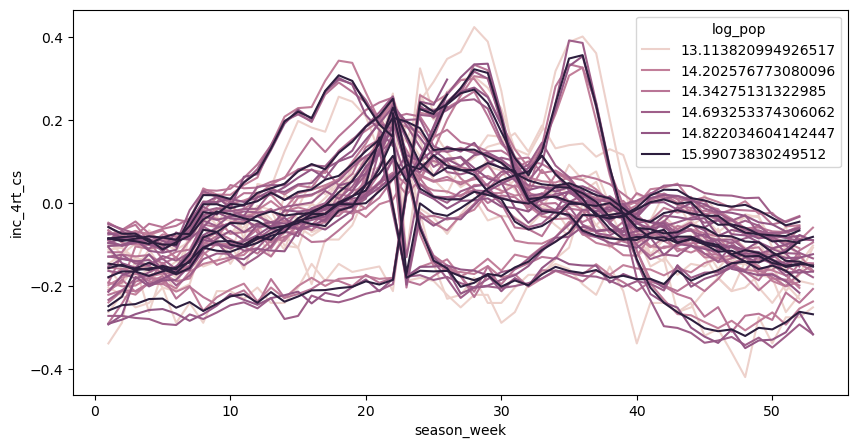

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

nhsn_to_plot = df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=nhsn_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax)

In [11]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [12]:
df

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs,inc_4rt_center_factor,location_Bronx,location_Brooklyn,location_Manhattan,location_NYC,location_Queens,location_Staten Island,xmas_week,delta_xmas
0,2024-10-05,Bronx,28.452033,1472654,40,2024,2024/25,10,14.202577,2.309758,...,-0.034306,0.756499,1,0,0,0,0,0,NaN,NaN
1,2024-10-12,Bronx,31.847264,1472654,41,2024,2024/25,11,14.202577,2.375758,...,-0.013670,0.756499,1,0,0,0,0,0,NaN,NaN
2,2024-10-19,Bronx,35.378303,1472654,42,2024,2024/25,12,14.202577,2.439018,...,0.006110,0.756499,1,0,0,0,0,0,NaN,NaN
3,2024-10-26,Bronx,38.162393,1472654,43,2024,2024/25,13,14.202577,2.485635,...,0.020686,0.756499,1,0,0,0,0,0,NaN,NaN
4,2024-11-02,Bronx,31.779359,1472654,44,2024,2024/25,14,14.202577,2.374491,...,-0.014066,0.756499,1,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,2024-11-30,Staten Island,13.313242,495747,48,2024,2024/25,18,13.113821,1.910524,...,0.023823,0.739318,0,0,0,0,0,1,NaN,NaN
2899,2024-12-07,Staten Island,17.952706,495747,49,2024,2024/25,19,13.113821,2.058699,...,0.083010,0.739318,0,0,0,0,0,1,NaN,NaN
2900,2024-12-14,Staten Island,19.969864,495747,50,2024,2024/25,20,13.113821,2.114210,...,0.105183,0.739318,0,0,0,0,0,1,NaN,NaN
2901,2024-12-21,Staten Island,22.390453,495747,51,2024,2024/25,21,13.113821,2.175526,...,0.129675,0.739318,0,0,0,0,0,1,NaN,NaN


In [13]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Bronx',
 'location_Brooklyn',
 'location_Manhattan',
 'location_NYC',
 'location_Queens',
 'location_Staten Island',
 'delta_xmas']

In [ ]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     wk_end_date       location        inc      pop  epiweek  year   season  \
0     2024-10-05          Bronx  28.452033  1472654       40  2024  2024/25   
1     2024-10-12          Bronx  31.847264  1472654       41  2024  2024/25   
2     2024-10-19          Bronx  35.378303  1472654       42  2024  2024/25   
3     2024-10-26          Bronx  38.162393  1472654       43  2024  2024/25   
4     2024-11-02          Bronx  31.779359  1472654       44  2024  2024/25   
...          ...            ...        ...      ...      ...   ...      ...   
2898  2024-11-30  Staten Island  13.313242   495747       48  2024  2024/25   
2899  2024-12-07  Staten Island  17.952706   495747       49  2024  2024/25   
2900  2024-12-14  Staten Island  19.969864   495747       50  2024  2024/25   
2901  2024-12-21  Staten Island  22.390453   495747       51  2024  2024/25   
2902  2024-12-28  Staten Island  38.326001   495747       52  2024  2024/25   

     season_week    log_pop   inc_4rt  ...  \
0    

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [15]:
df.shape

(2903, 59)

In [16]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [17]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     wk_end_date       location        inc      pop  epiweek  year   season  \
0     2024-10-05          Bronx  28.452033  1472654       40  2024  2024/25   
1     2024-10-12          Bronx  31.847264  1472654       41  2024  2024/25   
2     2024-10-19          Bronx  35.378303  1472654       42  2024  2024/25   
3     2024-10-26          Bronx  38.162393  1472654       43  2024  2024/25   
4     2024-11-02          Bronx  31.779359  1472654       44  2024  2024/25   
...          ...            ...        ...      ...      ...   ...      ...   
2898  2024-11-30  Staten Island  13.313242   495747       48  2024  2024/25   
2899  2024-12-07  Staten Island  17.952706   495747       49  2024  2024/25   
2900  2024-12-14  Staten Island  19.969864   495747       50  2024  2024/25   
2901  2024-12-21  Staten Island  22.390453   495747       51  2024  2024/25   
2902  2024-12-28  Staten Island  38.326001   495747       52  2024  2024/25   

     season_week    log_pop   inc_4rt  

In [18]:
df_with_pred_targets.shape

(14515, 62)

In [19]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
559,2024-12-28,Bronx,86.103049,1472654,52,2024,2024/25,22,14.202577,3.046262,...,0.083397,0.027231,0.016751,0.054328,0.071695,0.076077,0.089151,NaN,1,NaN
1028,2024-12-28,Brooklyn,57.673879,2736074,52,2024,2024/25,22,14.822035,2.755901,...,0.115142,0.031663,0.018702,-0.087426,-0.086575,-0.082011,-0.091015,NaN,1,NaN
1497,2024-12-28,Manhattan,44.621488,1694251,52,2024,2024/25,22,14.342751,2.584701,...,0.066237,0.022144,0.006011,-0.148512,-0.148601,-0.148078,-0.142269,NaN,1,NaN
1965,2024-12-21,NYC,48.851740,8804190,51,2024,2024/25,21,15.990738,2.643883,...,0.066741,0.016697,0.014542,-0.028395,0.039082,0.023907,0.078362,NaN,1,NaN
2432,2024-12-21,Queens,45.853939,2405464,51,2024,2024/25,21,14.693253,2.602363,...,0.026297,0.010859,0.002599,0.230888,0.257845,0.211515,0.187637,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,2024-11-30,Staten Island,13.313242,495747,48,2024,2024/25,18,13.113821,1.910524,...,-0.026201,0.023198,0.002744,0.019833,-0.022799,-0.012998,-0.036238,NaN,5,NaN
2899,2024-12-07,Staten Island,17.952706,495747,49,2024,2024/25,19,13.113821,2.058699,...,0.026063,0.023227,0.023198,0.033554,0.019833,0.005378,-0.012998,NaN,5,NaN
2900,2024-12-14,Staten Island,19.969864,495747,50,2024,2024/25,20,13.113821,2.114210,...,0.040820,0.027742,0.023227,0.053417,0.033554,0.036625,0.005378,NaN,5,NaN
2901,2024-12-21,Staten Island,22.390453,495747,51,2024,2024/25,21,13.113821,2.175526,...,0.076388,0.025733,0.027742,0.094097,0.053417,0.063826,0.036625,NaN,5,NaN


In [20]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [21]:
df_with_pred_targets2.shape

(11425, 62)

In [ ]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [ ]:
df_with_pred_targets = df_with_pred_targets2

# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']


# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

# Convert season_week and delta_xmas to numeric
x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

#print(x_train.dtypes[x_train.dtypes == 'object'])
#print(x_test.dtypes[x_test.dtypes == 'object'])

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
        # fit to bag
        model = lgb.LGBMRegressor(verbosity=-1,
                                    # hist_pool_size=1000,
                                    # objective='mean_absolute_error')
                                    objective='quantile',
                                    alpha = q_level,
                                    random_state=lgb_seeds[b, q_ind])
        model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
        
        # oob predictions and test set predictions
        #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
        test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_61714/753429204.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_61714/753429204.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_61714/753429204.py:35: SettingWithCopyW

bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [24]:
#oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
test_pred_qs_sorted.shape

test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,-0.449556,-0.449267,-0.426537,-0.221159,-0.158904,-0.055424,-0.003368,0.015204,0.026561
1,-0.483825,-0.455486,-0.412928,-0.241193,-0.164582,-0.057113,-0.010940,0.003829,0.027116
2,-0.469486,-0.467335,-0.421583,-0.223829,-0.156356,-0.054063,-0.006723,0.012313,0.026984
3,-0.438466,-0.437769,-0.416444,-0.215528,-0.149064,-0.055084,-0.003387,0.013824,0.028225
4,-0.361519,-0.359788,-0.292186,-0.149147,-0.095456,-0.032334,0.004016,0.021501,0.033349
5,-0.352142,-0.347699,-0.295911,-0.151473,-0.087421,-0.039406,0.009898,0.023683,0.038109
6,-0.449727,-0.430516,-0.414934,-0.294604,-0.234019,-0.083448,-0.017574,0.012825,0.034776
7,-0.482974,-0.436948,-0.411918,-0.318724,-0.237740,-0.097493,-0.031505,0.005399,0.033934
8,-0.467104,-0.445977,-0.418240,-0.300377,-0.234083,-0.084853,-0.020692,0.010989,0.035093
9,-0.436626,-0.421760,-0.407100,-0.283026,-0.234110,-0.085323,-0.016049,0.013562,0.036697


In [25]:
df_test.reset_index(drop=True, inplace=True)
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,delta_target,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,2025-01-18,Bronx,112.925371,1472654,3,2025,2025/26,26,14.202577,3.259924,...,-0.447106,-0.449556,-0.449267,-0.426537,-0.221159,-0.158904,-0.055424,-0.003368,0.015204,0.026561
1,2025-01-18,Brooklyn,74.449741,2736074,3,2025,2025/26,26,14.822035,2.937517,...,-0.493669,-0.483825,-0.455486,-0.412928,-0.241193,-0.164582,-0.057113,-0.010940,0.003829,0.027116
2,2025-01-18,Manhattan,56.839276,1694251,3,2025,2025/26,26,14.342751,2.745878,...,-0.469277,-0.469486,-0.467335,-0.421583,-0.223829,-0.156356,-0.054063,-0.006723,0.012313,0.026984
3,2025-01-18,NYC,76.520384,8804190,3,2025,2025/26,26,15.990738,2.957730,...,-0.431671,-0.438466,-0.437769,-0.416444,-0.215528,-0.149064,-0.055084,-0.003387,0.013824,0.028225
4,2025-01-18,Queens,70.797152,2405464,3,2025,2025/26,26,14.693253,2.900810,...,-0.361501,-0.361519,-0.359788,-0.292186,-0.149147,-0.095456,-0.032334,0.004016,0.021501,0.033349
5,2025-01-18,Staten Island,34.493401,495747,3,2025,2025/26,26,13.113821,2.423625,...,-0.352040,-0.352142,-0.347699,-0.295911,-0.151473,-0.087421,-0.039406,0.009898,0.023683,0.038109
6,2025-01-18,Bronx,112.925371,1472654,3,2025,2025/26,26,14.202577,3.259924,...,-0.285319,-0.449727,-0.430516,-0.414934,-0.294604,-0.234019,-0.083448,-0.017574,0.012825,0.034776
7,2025-01-18,Brooklyn,74.449741,2736074,3,2025,2025/26,26,14.822035,2.937517,...,-0.328565,-0.482974,-0.436948,-0.411918,-0.318724,-0.237740,-0.097493,-0.031505,0.005399,0.033934
8,2025-01-18,Manhattan,56.839276,1694251,3,2025,2025/26,26,14.342751,2.745878,...,-0.300942,-0.467104,-0.445977,-0.418240,-0.300377,-0.234083,-0.084853,-0.020692,0.010989,0.035093
9,2025-01-18,NYC,76.520384,8804190,3,2025,2025/26,26,15.990738,2.957730,...,-0.261807,-0.436626,-0.421760,-0.407100,-0.283026,-0.234110,-0.085323,-0.016049,0.013562,0.036697


In [26]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['wk_end_date' ,'location', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                id_vars=cols_to_keep,
                var_name='quantile',
                value_name = 'delta_hat')
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat
0,2025-01-18,Bronx,1472654,0.262783,1,0.756499,3.188256,0.025,-0.449556
1,2025-01-18,Brooklyn,2736074,0.297261,1,0.763240,2.759931,0.025,-0.483825
2,2025-01-18,Manhattan,1694251,0.265797,1,0.762653,2.659917,0.025,-0.469486
3,2025-01-18,NYC,8804190,0.260889,1,0.758698,2.890912,0.025,-0.438466
4,2025-01-18,Queens,2405464,0.231019,1,0.764545,2.903733,0.025,-0.361519
...,...,...,...,...,...,...,...,...,...
265,2025-01-18,Brooklyn,2736074,0.297261,5,0.763240,2.759931,0.975,0.033349
266,2025-01-18,Manhattan,1694251,0.265797,5,0.762653,2.659917,0.975,0.033513
267,2025-01-18,NYC,8804190,0.260889,5,0.758698,2.890912,0.975,0.036975
268,2025-01-18,Queens,2405464,0.231019,5,0.764545,2.903733,0.975,0.038613


In [27]:
# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat,inc_4rt_cs_target_hat,inc_4rt_target_hat,value
0,2025-01-18,Bronx,1472654,0.262783,1,0.756499,3.188256,0.025,-0.449556,-0.186773,1.822130,157.530261
1,2025-01-18,Brooklyn,2736074,0.297261,1,0.763240,2.759931,0.025,-0.483825,-0.186564,1.597355,169.197704
2,2025-01-18,Manhattan,1694251,0.265797,1,0.762653,2.659917,0.025,-0.469486,-0.203688,1.492390,78.514003
3,2025-01-18,NYC,8804190,0.260889,1,0.758698,2.890912,0.025,-0.438466,-0.177578,1.685777,682.295666
4,2025-01-18,Queens,2405464,0.231019,1,0.764545,2.903733,0.025,-0.361519,-0.130500,1.847440,272.356267
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2025-01-18,Brooklyn,2736074,0.297261,5,0.763240,2.759931,0.975,0.033349,0.330610,3.029890,2296.942654
266,2025-01-18,Manhattan,1694251,0.265797,5,0.762653,2.659917,0.975,0.033513,0.299310,2.835354,1089.451841
267,2025-01-18,NYC,8804190,0.260889,5,0.758698,2.890912,0.975,0.036975,0.297864,3.064991,7740.998630
268,2025-01-18,Queens,2405464,0.231019,5,0.764545,2.903733,0.975,0.038613,0.269633,3.013319,1975.407612


In [28]:
# keep just required columns and rename to match hub format
preds_df = preds_df[['wk_end_date', 'location', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['target'] = 'ILI ED Visits'
preds_df['horizon'] = preds_df['horizon'] - 1

preds_df['output_type'] = 'quantile'
preds_df



,wk_end_date,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,2025-01-18,Bronx,0,0.025,157.530261,2025-01-25,2025-01-25,ILI ED Visits,quantile
1,2025-01-18,Brooklyn,0,0.025,169.197704,2025-01-25,2025-01-25,ILI ED Visits,quantile
2,2025-01-18,Manhattan,0,0.025,78.514003,2025-01-25,2025-01-25,ILI ED Visits,quantile
3,2025-01-18,NYC,0,0.025,682.295666,2025-01-25,2025-01-25,ILI ED Visits,quantile
4,2025-01-18,Queens,0,0.025,272.356267,2025-01-25,2025-01-25,ILI ED Visits,quantile
...,...,...,...,...,...,...,...,...,...
265,2025-01-18,Brooklyn,4,0.975,2296.942654,2025-02-22,2025-01-25,ILI ED Visits,quantile
266,2025-01-18,Manhattan,4,0.975,1089.451841,2025-02-22,2025-01-25,ILI ED Visits,quantile
267,2025-01-18,NYC,4,0.975,7740.998630,2025-02-22,2025-01-25,ILI ED Visits,quantile
268,2025-01-18,Queens,4,0.975,1975.407612,2025-02-22,2025-01-25,ILI ED Visits,quantile


In [29]:
preds_df = preds_df[['reference_date', 'location', 'horizon', 'target', 'target_end_date', 'output_type', 'output_type_id', 'value']]
preds_df

,reference_date,location,horizon,target,target_end_date,output_type,output_type_id,value
0,2025-01-25,Bronx,0,ILI ED Visits,2025-01-25,quantile,0.025,157.530261
1,2025-01-25,Brooklyn,0,ILI ED Visits,2025-01-25,quantile,0.025,169.197704
2,2025-01-25,Manhattan,0,ILI ED Visits,2025-01-25,quantile,0.025,78.514003
3,2025-01-25,NYC,0,ILI ED Visits,2025-01-25,quantile,0.025,682.295666
4,2025-01-25,Queens,0,ILI ED Visits,2025-01-25,quantile,0.025,272.356267
...,...,...,...,...,...,...,...,...
265,2025-01-25,Brooklyn,4,ILI ED Visits,2025-02-22,quantile,0.975,2296.942654
266,2025-01-25,Manhattan,4,ILI ED Visits,2025-02-22,quantile,0.975,1089.451841
267,2025-01-25,NYC,4,ILI ED Visits,2025-02-22,quantile,0.975,7740.998630
268,2025-01-25,Queens,4,ILI ED Visits,2025-02-22,quantile,0.975,1975.407612


In [30]:
if not Path('GBQR/model_output/NYC_ED').exists():
    Path('GBQR/model_output/NYC_ED').mkdir(parents=True)

preds_df.to_csv(f'GBQR/model_output/NYC_ED/{str(ref_date)}-epiENGAGE-GBQR.csv', index=False)


In [ ]:
start_date = datetime(2025, 1, 25)
end_date = start_date + timedelta(days=1) 
#end_date = datetime(2024, 3, 30)


#start_date = datetime(2024, 10, 6)
#end_date = datetime(2024, 12, 1)

current_date = start_date
while current_date <= end_date:
    print(current_date.strftime('%Y-%m-%d'))  # Print or use the date as needed
    forecast_date = pd.to_datetime(current_date)

    # Filter the DataFrame based on the comparison
    df_with_pred_targets = df_with_pred_targets2[df_with_pred_targets2['collection_week'] <= forecast_date]
    df_with_pred_targets.shape
    
    # "test set" df used to generate look-ahead predictions
    df_test = df_with_pred_targets \
        .loc[df_with_pred_targets.collection_week == df_with_pred_targets.collection_week.max()] \
        .copy()
    x_test = df_test[feat_names]

    # "train set" df for model fitting; target value non-missing
    df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
    x_train = df_train[feat_names]
    y_train = df_train['delta_target']

    
    # seed for random number generation, based on reference date
    rng_seed = int(time.mktime(forecast_date.timetuple()))
    rng = np.random.default_rng(seed=rng_seed)
    # seeds for lgb model fits, one per combination of bag and quantile level
    lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

    # training loop over bags
    # for q_level, q_label in zip(q_levels, q_labels):
        # print(q_label)

    oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
    oob_preds_by_bag[:] = np.nan
    test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

    train_seasons = df_train['season'].unique()

    # Convert season_week and delta_xmas to numeric
    x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
    x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

    x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
    x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

    #print(x_train.dtypes[x_train.dtypes == 'object'])
    #print(x_test.dtypes[x_test.dtypes == 'object'])

    for b in range(num_bags):
        print(f'bag number {b+1}')
        # get indices of observations that are in bag
        bag_seasons = rng.choice(
            train_seasons,
            size = int(len(train_seasons) * bag_frac_samples),
            replace=False)
        bag_obs_inds = df_train['season'].isin(bag_seasons)
        
        for q_ind, q_level in enumerate(q_levels):
            # fit to bag
            model = lgb.LGBMRegressor(verbosity=-1,
                                        # hist_pool_size=1000,
                                        # objective='mean_absolute_error')
                                        objective='quantile',
                                        alpha = q_level,
                                        random_state=lgb_seeds[b, q_ind])
            model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
            
            # oob predictions and test set predictions
            #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
            test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

    # df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
    # df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

    #oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
    test_pred_qs = np.median(test_preds_by_bag, axis=1)
    test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
    test_pred_qs_sorted.shape

    test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
    test_pred_qs_df.columns = q_labels
    test_pred_qs_df

    df_test.reset_index(drop=True, inplace=True)
    df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)

    # delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
    cols_to_keep = ['location', 'collection_week', 'pop',
                    'inc_4rt_cs', 'horizon',
                    'inc_4rt_center_factor', 'inc_4rt_scale_factor']
    preds_df = df_test_w_preds[cols_to_keep + q_labels]
    preds_df = pd.melt(preds_df,
                    id_vars=cols_to_keep,
                    var_name='quantile',
                    value_name = 'delta_hat')

    # build data frame with predictions on the original scale
    preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
    preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
    preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
    preds_df['value'] = np.maximum(preds_df['value'], 0.0)

    # keep just required columns and rename to match hub format
    preds_df = preds_df[['location', 'collection_week', 'horizon', 'quantile', 'value']] \
        .rename(
            columns={
                'quantile': 'output_type_id'
            })

    preds_df['target_end_date'] = preds_df['collection_week'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
    preds_df['target'] = 'wk inc flu ED'

    preds_df['output_type'] = 'quantile'

    if not Path('GBM/model_output/NYC_ED').exists():
        Path('GBM/model_output/NYC_ED').mkdir(parents=True)

    preds_df.to_csv(f'GBM/model_output/NYC_ED/{str(forecast_date.date())}-GBM.csv', index=False)
    current_date += timedelta(weeks=1)

2025-01-25


KeyError: 'collection_week'